TODO: debugger détection des bbox.
TODO: être sûr qu'il n'y a pas de problèmes avec l'option normalized de la fonction d'obtention bbox

In [22]:
from __future__ import division, absolute_import, print_function
import os, sys, re
import numpy as np
from scipy import misc
from unrealcv import client
from pascal_voc_io import PascalVocWriter
import argparse
import json


DIFFICULT = 0
IMGSIZE = (1920, 1080, 3)
TOLERANCE = 3

_MODE = None

In [23]:
# Only for notebook
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [24]:
def read_png(res):
    img = misc.imread(res, mode=_MODE)
    return np.asarray(img)

In [4]:
class Color(object):
    ''' A utility class to parse color value '''
    regexp = re.compile('\(R=(.*),G=(.*),B=(.*),A=(.*)\)')

    def __init__(self, color_str):
        self.color_str = color_str
        match = self.regexp.match(color_str)
        (self.R, self.G, self.B, self.A) = [int(match.group(i)) for i in range(1, 5)]

    def __repr__(self):
        return self.color_str


def get_bbox(object_mask, target_color, tolerance=3, normalized=False):
    """Function that returns the coordinates of bbox associated with target_color mask
    The coordinates returned are (xmin, xmax, ymin, ymax)"""

    match_region = np.ones(object_mask.shape[0:2], dtype=bool)
    for c in range(3): # r,g,b
        min_val = target_color[c] - tolerance
        max_val = target_color[c] + tolerance
        channel_region = (object_mask[:,:,c] >= min_val) & (object_mask[:,:,c] <= max_val)
        match_region &= channel_region

    if match_region.sum() != 0:
        xbox, ybox = np.where(match_region)
        xmin, xmax = np.min(xbox), np.max(xbox)
        ymin, ymax = np.min(ybox), np.max(ybox)
        if not normalized:
            return xmin, xmax, ymin, ymax
        else:
            width = object_mask.shape[1]
            height = object_mask.shape[0]
            return xmin / width, xmax / width, ymin / height, ymax / height
    else:
        return None
    
    
def match_color(object_mask, target_color, tolerance=3):
    match_region = np.ones(object_mask.shape[0:2], dtype=bool)
    for c in range(3): # r,g,b
        min_val = target_color[c] - tolerance
        max_val = target_color[c] + tolerance
        channel_region = (object_mask[:,:,c] >= min_val) & (object_mask[:,:,c] <= max_val)
        match_region &= channel_region

    if match_region.sum() != 0:
        return match_region
    else:
        return None


def get_id2color(scene_objects):
    id2color = {}  # Map from object id to the labeling color
    for obj_id in scene_objects:
        color = Color(client.request('vget /object/%s/color' % obj_id))
        id2color[obj_id] = color
    return id2color


def write_VOC(id2bbox, id2category, filename, foldername='database', imgSize=IMGSIZE):
    writer = PascalVocWriter(filename, foldername, imgSize)
    ids = id2bbox.values()
    for id in ids:
        xmin, xmax, ymin, ymax = id2bbox[id]
        name = id2category[id]
        writer.addBndBox(xmin, ymin, xmax, ymax, name, DIFFICULT)
    writer.save(foldername+'{}.xml'.format(filename))

In [5]:
client.connect()
if not client.isconnected():
    print('UnrealCV server is not running. Run the game downloaded from http://unrealcv.github.io first.')
    sys.exit(-1)
res = client.request('vget /unrealcv/status')
# The image resolution and port is configured in the config file.
print(res)

camera_trajectory = json.load(open('camera_traj.json'))
with open('object_category2.json') as f:
    id2category = json.load(f)
print('done')

INFO:__init__:204:Got connection confirm: 'connected to shelf1'


Is Listening
Client Connected
9000
Configuration
Config file: D:/Programmes/Epic Games/UE_4.13/Engine/Binaries/Win64/unrealcv.ini
Port: 9000
Width: 1920
Height: 1080

done


In [25]:
num_cameras = len(camera_trajectory)
# for idx in range(num_cameras):
idx = 0
loc, rot = camera_trajectory[idx]
client.request('vset /camera/{id}/location {x} {y} {z}'.format(id=idx, **loc))
client.request('vset /camera/{id}/rotation {pitch} {yaw} {roll}'.format(id=idx, **rot))
# Get image
res = client.request('vget /camera/{id}/lit {id}.png'.format(id=idx))
print('The image is saved to %s' % res)

custom_img = read_png(res)
print('image dimension : ', np.shape(custom_img))

# Generate image mask
res = client.request('vget /camera/{id}/object_mask mask_{id}.png'.format(id=idx))
object_mask = read_png(res)
print('mask dimension : ', np.shape(object_mask))

# Associate images to all objects ids
scene_objects = client.request('vget /objects').split(' ')
print('Number of objects in this scene:', len(scene_objects))

id2color = get_id2color(scene_objects)
id2bbox = {}
for obj_id in id2color:
    color = id2color[obj_id]
    bbox = get_bbox(object_mask, [color.R, color.G, color.B], tolerance=TOLERANCE)
    if bbox is not None and obj_id in id2category:
        print(obj_id, bbox)
        id2bbox[obj_id] = bbox

The image is saved to D:/Programmes/Epic Games/UE_4.13/Engine/Binaries/Win64/0.png
image dimension :  (1080L, 1920L, 4L)
mask dimension :  (460L, 623L, 4L)
Number of objects in this scene: 85
novanuit14_17 (293, 344, 394, 442)
doliprane_otx_gelule_1028 (157, 184, 315, 376)
rhinadvil19 (214, 234, 10, 20)
rhinadvil18 (0, 5, 87, 227)
drill-bleu7_82 (81, 134, 57, 121)
nuronfen_415 (134, 331, 0, 77)
novanuit28 (387, 441, 145, 193)
nuronfen_416 (335, 335, 614, 614)
nuronfen_411 (353, 433, 41, 96)
nuronfen_412 (14, 428, 15, 614)
novanuit22 (292, 454, 20, 243)
novanuit20 (367, 428, 341, 434)
doliprane_otx_gelule_19 (312, 339, 347, 406)
novanuit26 (290, 335, 103, 146)
novanuit27 (376, 421, 112, 154)
novanuit24 (6, 428, 12, 607)
novanuit25 (289, 340, 244, 288)
novanuit18 (291, 341, 298, 341)
doliprane_otx_gelule_1018 (406, 433, 201, 255)
doliprane_otx_gelule_1027 (182, 210, 358, 425)
rhinadvil14_16 (80, 113, 213, 272)
novanuit23 (378, 406, 204, 246)
drill-bleu5_62 (385, 428, 0, 17)
doliprane_otx

In [26]:
problematic_id = 'novanuit24'

6 428 12 607


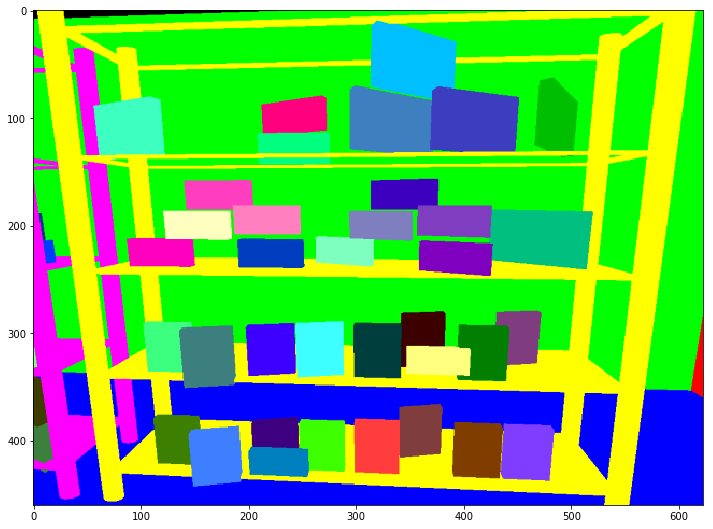

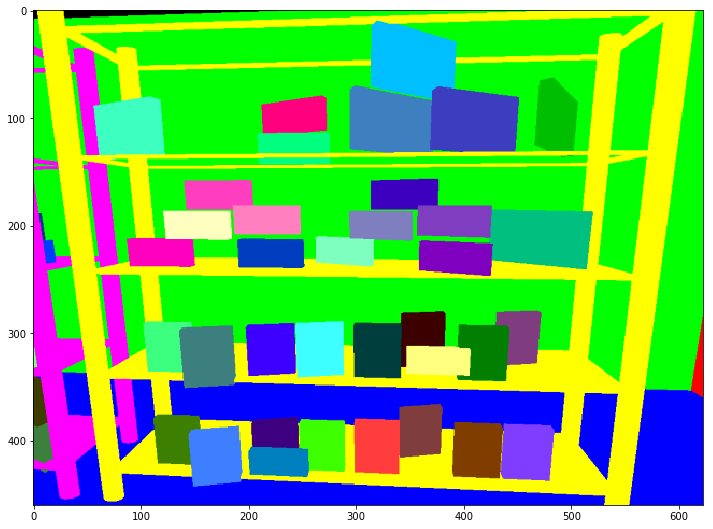

In [32]:
# Create figure and axes
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)

# Display the image
ax.imshow(object_mask)
xmin, xmax, ymin, ymax = id2bbox[problematic_id]
print(xmin, xmax, ymin, ymax)
#rect = patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
#rect = patches.Rectangle((ymin,xmin),ymax-ymin,xmax-xmin, linewidth=1, edgecolor='r', facecolor='none')
#ax.add_patch(rect)

plt.show()

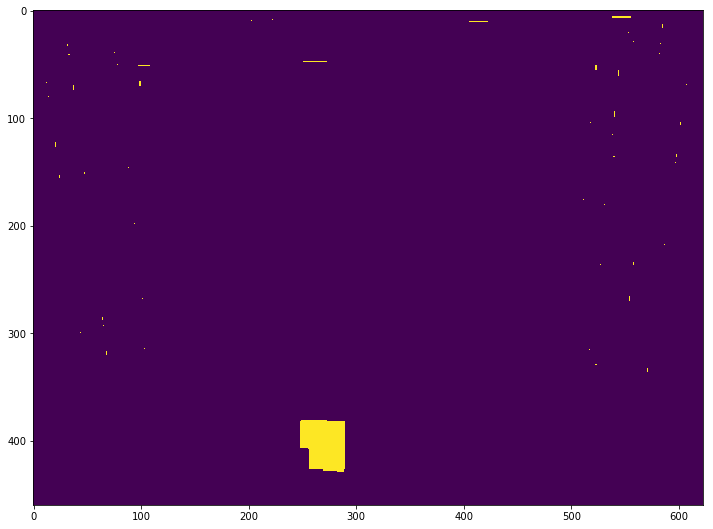

In [28]:
# Create figure and axes
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)

# Display the image
color = id2color[problematic_id]
mask = match_color(object_mask, [color.R, color.G, color.B], tolerance = 3)
ax.imshow(mask)

plt.show()

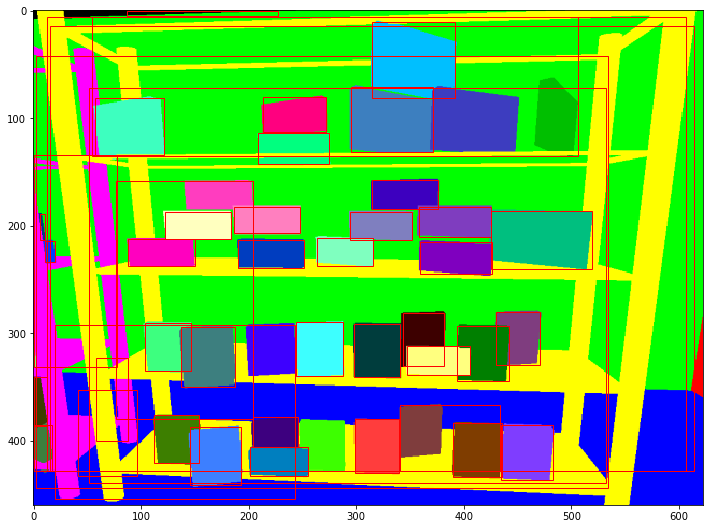

In [33]:
# Create figure and axes
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)

# Display the image
ax.imshow(object_mask)
for (xmin, xmax, ymin, ymax) in id2bbox.values():
    
    #rect = patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
    rect = patches.Rectangle((ymin,xmin),ymax-ymin,xmax-xmin, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()

Constat : fonction semble fonctioner

In [31]:
for idx in id2color:
    print(idx)

novanuit14_17
Wall_400x200_2
drill-bleu2_14
doliprane_otx_gelule_1028
rhinadvil17
Floor
rhinadvil19
rhinadvil18
dafalgan_133
drill-bleu7_82
WorldSettings_1
drill-bleu_204
nuronfen_415
nuronfen_414
novanuit28
nuronfen_416
nuronfen_411
nuronfen_410
nuronfen_413
nuronfen_412
novanuit22
rhinadvil15
novanuit20
doliprane_otx_gelule_19
novanuit26
novanuit27
novanuit24
novanuit25
dafalgan8_28
novanuit18
novanuit31
Wall_400x202
doliprane_otx_gelule_1018
dafalgan11
doliprane_otx_gelule_1027
nuronfen_407
rhinadvil14_16
novanuit23
drill-bleu5_62
doliprane_otx_gelule_1022
drill-bleu11_90
dafalgan10_65
doliprane_otx_gelule_1024
nuronfen_20
doliprane_otx_gelule_1025
drill-bleu6_63
doliprane_otx_gelule_1019
drill-bleu3_58
doliprane_otx_gelule_1023
rhinadvil24
rhinadvil20
drill-bleu12_92
rhinadvil13_15
dafalgan3_18
rhinadvil21
drill-bleu13
nuronfen_408
nuronfen_409
novanuit17
novanuit16
novanuit15
drill-bleu10_88
dafalgan5_22
novanuit30
novanuit19
rhinadvil23
nuronfen_406
Wall_400x201_10
dafalgan7_26
d

In [30]:
for idx in id2category:
    print(idx)

rhinadvil11
rhinadvil10
rhinadvil13
rhinadvil12
rhinadvil3_191
rhinadvil14
rhinadvil17
drill-bleu3_208
rhinadvil19
rhinadvil18
dafalgan_133
novanuit2_167
drill-bleu_204
dafalgan2_135
nuronfen_408
dafalgan4_139
drill-bleu2_206
dafalgan14
novanuit11
dafalgan20
dafalgan21
rhinadvil2_189
novanuit3_169
doliprane_otx_gelule_158
dafalgan12
novanuit_165
dafalgan15
rhinadvil16_263
nuronfen_184
doliprane_otx_gelule_154
nuronfen_182
doliprane_otx_gelule_156
nuronfen_180
doliprane_otx_gelule_222
rhinadvil7
dafalgan7_145
doliprane_otx_gelule_226
dafalgan17
doliprane_otx_gelule_224
dafalgan5_141
dafalgan16
rhinadvil9
rhinadvil8
drill-bleu4_210
nuronfen_176
rhinadvil6
nuronfen_174
rhinadvil_187
drill-bleu5_212
dafalgan10_151
nuronfen_178
doliprane_otx_gelule_1013
doliprane_otx_gelule_1012
dafalgan8_147
novanuit8
doliprane_otx_gelule_216
dafalgan11
dafalgan13
doliprane_otx_gelule_220
nuronfen_406
dafalgan9_149
nuronfen_407
doliprane_otx_gelule_245
doliprane_otx_gelule_160
novanuit9
doliprane_otx_gelul

In [ ]:
client.disconnect()